# **Filtering and trimming messages:**

let's talk a bit more about advanced ways to work with messages in graph state.

## **Set Up:**

In [1]:
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community

In [2]:
# For Colab, use this:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    temperature=0,
    api_key=GEMINI_API_KEY
)

## **Messages as state:**

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Ammar"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Ammar

Yes, I know about whales. But what others should I learn about?


Let's pass the same message to our llm

In [5]:
#llm.invoke(messages)

generated_message= llm.invoke(messages)
generated_message.pretty_print()

================================== Ai Message ==================================

That's great! Whales are fascinating creatures.  Here are some other ocean mammals you might find interesting to learn about:

**Marine Mammals:**

* **Dolphins:**  These intelligent and social animals are found in all oceans. There are over 40 different species, each with unique characteristics.
* **Porpoises:**  Often confused with dolphins, porpoises are smaller and have a more blunt snout. They are also known for their high-pitched whistles.
* **Seals:**  These sleek, streamlined animals are found in both cold and warm waters. They are known for their ability to hold their breath for long periods of time.
* **Sea Lions:**  Similar to seals, but with larger flippers and the ability to walk on land. They are also known for their loud barks.
* **Walruses:**  These massive animals are found in the Arctic and are known for their large tusks. They use their tusks to dig for food and to defend themselves.
* 

## **Integrate Model Invocation into LangGraph with MessagesState:**

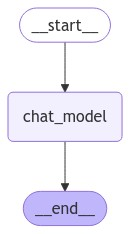

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Ammar

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating creatures.  Here are some other ocean mammals you might find interesting to learn about:

**Marine Mammals:**

* **Dolphins:**  These intelligent and social animals are found in all oceans. There are over 40 different species, each with unique characteristics.
* **Porpoises:**  Often confused with dolphins, porpoises are smaller and have a more blunt snout. They are also known for their high-pitched whistles.
* **Seals:**  These sleek, streamlined animals are found in both cold and warm waters. They are known for their ability to hold their breath for long periods of time.
* *

## **Reducer for Managing Long-Running Conversations:**

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

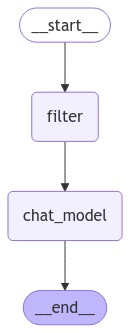

In [8]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import RemoveMessage, AIMessage, HumanMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

* **Purpose of Reducer:** Reduces the number of messages by removing all but the last two, which helps control memory usage in long conversations. Without this, the growing message history would lead to high token usage, slower responses, and possibly exceed token limits.
* **Integrating Filter Node in the Graph:** Adds the filter_messages node to the graph before chat_model_node. This way, each time the graph is invoked, the filter node trims the message history before sending it to the model.

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Ammar", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Ammar", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Ammar

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating creatures.  Here are some other ocean mammals you might find interesting to learn about:

**Marine Mammals:**

* **Dolphins:**  These intelligent and social animals are found in all oceans. There are over 40 different species, each with unique characteristics.
* **Porpoises:**  Often mistaken for dolphins, porpoises are smaller and have a more blunt snout. They are also known for their high-pitched whistles.
* **Seals:**  These sleek, streamlined animals are found in both cold and warm waters. They are divided into two main groups: earless seals and eared seals.
* **Sea Lions:

## **Filtering messages:**

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

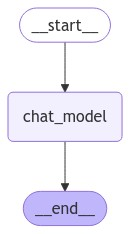

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

**Purpose:** Instead of modifying the state permanently, this approach filters messages directly in the model call. Only the last message is sent to the model, making the model behave like a short-term memory system.

**Efficiency:** Reduces token usage even further by passing only the most recent message in each invocation.

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Ammar"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Ammar

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Ammar

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating creatures.  Here are some other ocean mammals you might find interesting to learn about:

**Marine Mammals:**

* **Dolphins:**  These intelligent and social animals are found in all oceans. There are over 40 different species, each with unique characteristics.
* **Porpoises:**  Often mistaken for dolphins, porpoises are smaller and have a more blunt snout. They are also known for their 

In [12]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Ammar

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Ammar

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great! Whales are fascinating creatures.  Here are some other ocean mammals you might find interesting to learn about:

**Marine Mammals:**

* **Dolphins:**  These intelligent and social animals are found in all oceans. There are over 40 different species, each with unique characteristics.
* **Porpoises:**  Often mistaken for dolphins, porpoises are smaller and have a more blunt snout. They are also known for their 

**The state has all of the mesages.**

## **Trim messages:**

**Trimming:** Unlike filtering, trimming is based on token count, ensuring the history fits within a set token range, which can be essential when managing costs and performance in large conversations.

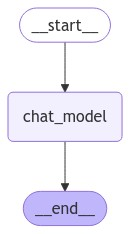

In [13]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=llm,
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Ammar"))

In [15]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})